# UC Deep Learning

## 0. Bibliotecas, módulos, classes necessárias

In [1]:
# Instalar Augmentor
!pip install Augmentor

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import Augmentor

## 1. Introdução

Neste projeto desenvolvo um modelo de rede neuronal convolucional (CNN) com o objetivo de classificar imagens de lesões de pele, incluindo o melanoma — uma das formas mais agressivas de cancro de pele. Com base em imagens disponibilizadas pela ISIC, construí um pipeline de classificação multiclasse utilizando TensorFlow, focado na deteção precoce e precisa.

As principais etapas do projeto incluem a análise dos dados, preparação do conjunto de treino, construção e avaliação de modelos, aplicação de estratégias para evitar overfitting e lidar com desequilíbrios de classe.


## 2. Pré-Processamento

In [7]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/dataset/Train"

IMG_SIZE = (180, 180)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Mounted at /content/drive
Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


## 3. Visualização de Dados

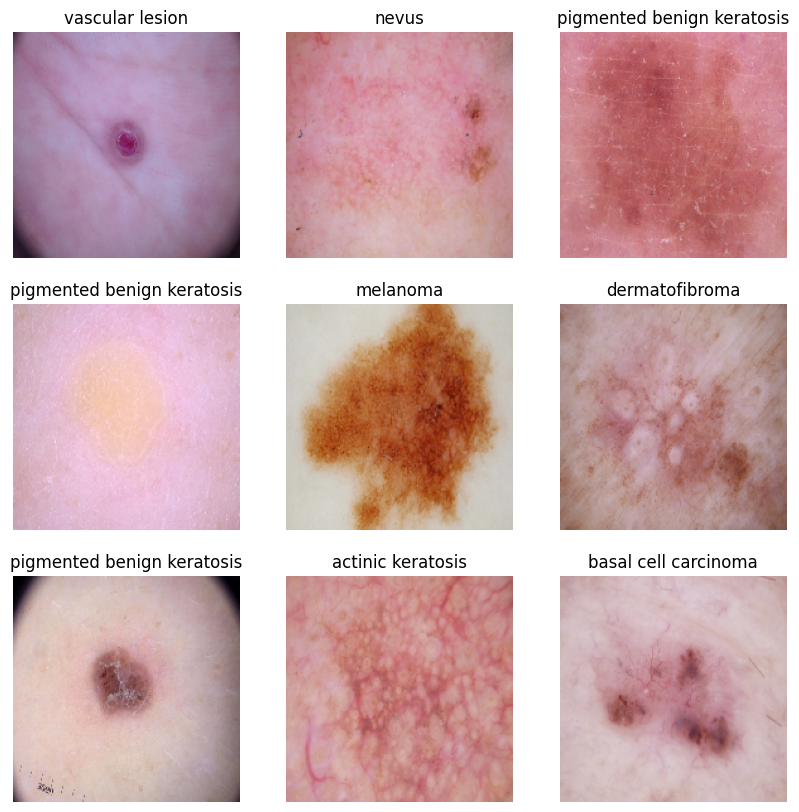

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Distribuição de Classes no Conjunto de Treino

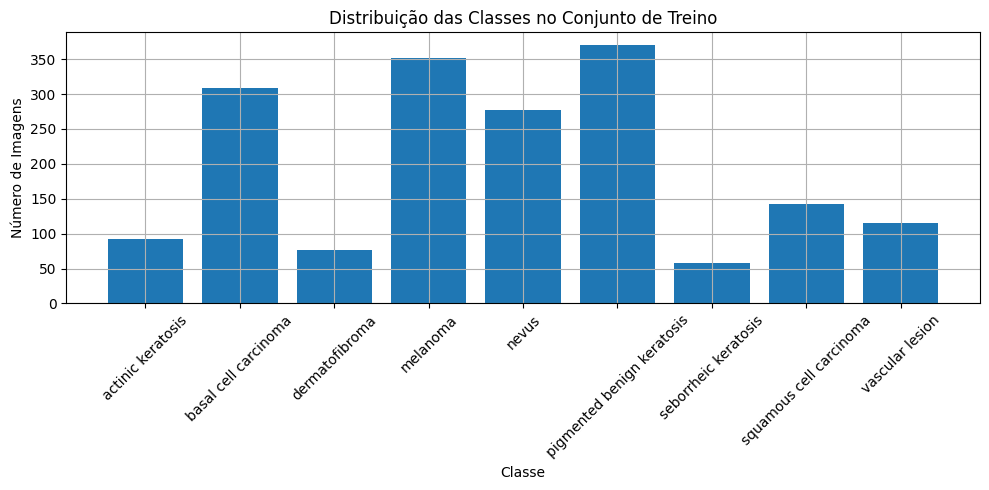

In [9]:
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())

unique, counts = np.unique(all_labels, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(class_names, counts)
plt.xticks(rotation=45)
plt.title("Distribuição das Classes no Conjunto de Treino")
plt.ylabel("Número de Imagens")
plt.xlabel("Classe")
plt.grid(True)
plt.tight_layout()
plt.show()

Este gráfico mostra quantas imagens existem para cada uma das 9 classes do conjunto de treino.

Podemos ver que algumas classes têm muitas mais imagens do que outras. Por exemplo, classes como 'melanoma' e 'nevus' têm mais de 300 imagens, enquanto outras como 'seborrheic keratosis' e 'dermatofibroma' têm menos de 100.

Isto pode ser um problema porque o modelo vai aprender mais facilmente as classes que aparecem mais vezes, e pode ter dificuldade em reconhecer as que aparecem pouco.

Por isso, mais à frente no projeto, usei duas estratégias para resolver este desequilíbrio:
- Atribuir mais “peso” às classes com menos imagens (`class_weight`)
- Criar novas imagens com `Augmentor` para aumentar o número de exemplos dessas classes


## 4. Modelagem e Iterações

Foram realizadas várias iterações de treino, com diferentes estratégias para melhorar a performance do modelo. Abaixo segue a implementação progressiva:

### 4.1 Modelo Base CNN

In [10]:
# Criar o modelo CNN
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),  # Normalização

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Saída multiclasse
])

# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Ver resumo do modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.1940 - loss: 2.5418 - val_accuracy: 0.1902 - val_loss: 2.0302
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 321ms/step - accuracy: 0.2641 - loss: 1.9456 - val_accuracy: 0.3445 - val_loss: 1.7992
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - accuracy: 0.3429 - loss: 1.7480 - val_accuracy: 0.4430 - val_loss: 1.6100
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - accuracy: 0.4415 - loss: 1.5594 - val_accuracy: 0.5168 - val_loss: 1.4435
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 323ms/step - accuracy: 0.4923 - loss: 1.4287 - val_accuracy: 0.4765 - val_loss: 1.5250
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 318ms/step - accuracy: 0.5218 - loss: 1.3461 - val_accuracy: 0.5145 - val_loss: 1.3791
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 324ms/step - accuracy: 0.5493 - loss: 1.2599 - val_accuracy: 0.5280 - val_loss: 1.3727
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 290ms/step - accuracy: 0.5520 - loss: 1.2749 - val_accura

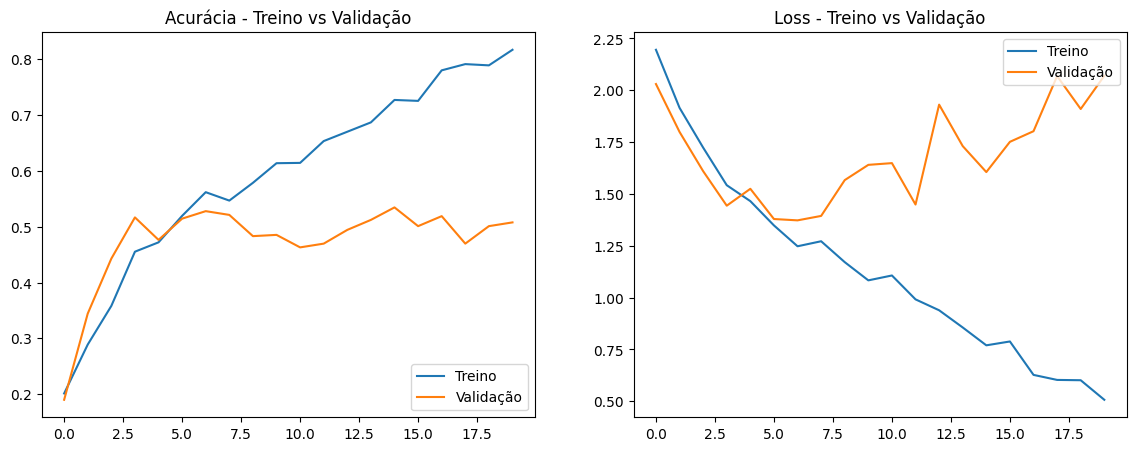

In [12]:
# Extrair métricas do histórico
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plotar accuracy e loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.legend(loc='lower right')
plt.title('Acurácia - Treino vs Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino')
plt.plot(epochs_range, val_loss, label='Validação')
plt.legend(loc='upper right')
plt.title('Loss - Treino vs Validação')

plt.show()

Neste primeiro treino com a CNN base, o modelo conseguiu atingir uma accuracy de treino superior a 80%, mostrando que foi capaz de aprender os padrões do conjunto de treino.

Contudo, a accuracy de validação estabilizou por volta dos 50% e o valor da loss aumentou nas últimas épocas. Isto mostra que o modelo começou a decorar os dados do treino e a perder capacidade de generalizar — o que é um caso clássico de overfitting.

Esta observação justifica o uso, nas próximas iterações, de técnicas como:
- `data augmentation` para aumentar a diversidade visual
- `dropout` para ajudar na regularização
- `class_weight` ou `Augmentor` para lidar com o desequilíbrio das classes


### 4.2 CNN com Data Augmentation

In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [14]:
model_aug = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model_aug.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_aug.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_aug = model_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 310ms/step - accuracy: 0.1971 - loss: 2.3097 - val_accuracy: 0.3244 - val_loss: 1.8382
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 283ms/step - accuracy: 0.3309 - loss: 1.8071 - val_accuracy: 0.3714 - val_loss: 1.7371
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 329ms/step - accuracy: 0.4186 - loss: 1.6378 - val_accuracy: 0.4720 - val_loss: 1.5480
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 326ms/step - accuracy: 0.4461 - loss: 1.5705 - val_accuracy: 0.5034 - val_loss: 1.4255
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 328ms/step - accuracy: 0.5063 - loss: 1.4615 - val_accuracy: 0.5190 - val_loss: 1.4104
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step - accuracy: 0.5313 - loss: 1.3406 - val_accuracy: 0.4944 - val_loss: 1.4453
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 326ms/step - accuracy: 0.4895 - loss: 1.4034 - val_accuracy: 0.5145 - val_loss: 1.3858
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.5110 - loss: 1.3506 - val_accu

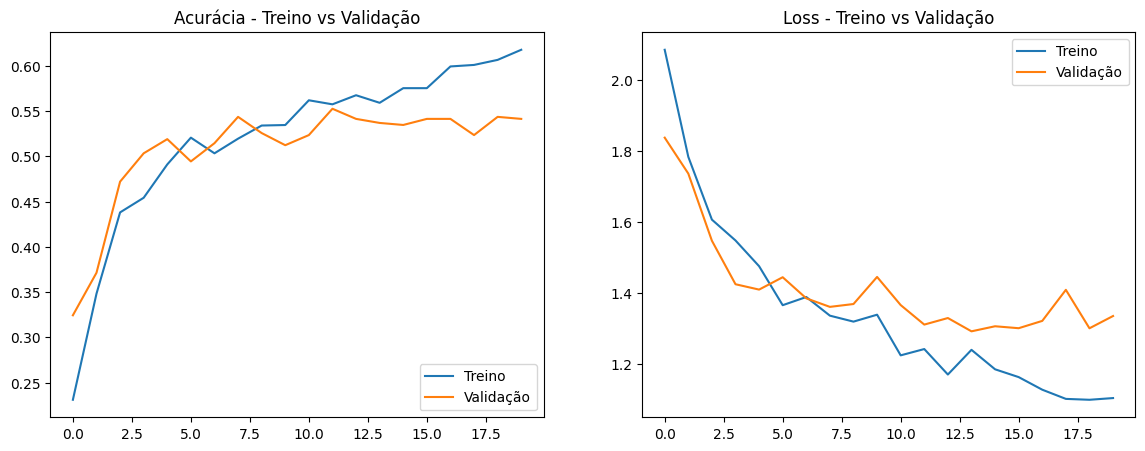

In [16]:
# Extrair métricas do histórico
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs_range = range(len(acc))

# Plotar accuracy e loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.legend(loc='lower right')
plt.title('Acurácia - Treino vs Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino')
plt.plot(epochs_range, val_loss, label='Validação')
plt.legend(loc='upper right')
plt.title('Loss - Treino vs Validação')

plt.show()

Neste modelo foi introduzido `data augmentation` (rotação, zoom, flip horizontal) como técnica para aumentar a diversidade das imagens durante o treino, sem alterar os dados originais.

O impacto foi positivo: a accuracy de treino atingiu cerca de 62% e a de validação estabilizou em torno dos 54%, melhor do que no modelo base. A loss de validação manteve-se mais estável e baixa (~1.3), o que indica que o modelo generalizou melhor e sofreu menos overfitting.

O gráfico mostra que as curvas de treino e validação estão mais próximas do que anteriormente, o que sugere que o modelo está a aprender de forma mais equilibrada. A oscilação da curva de validação é menor, o que também reforça esta melhoria.

Este resultado confirma que o data augmentation ajuda o modelo a aprender padrões mais robustos e a adaptar-se melhor a variações naturais nas imagens.


### 4.3 CNN com Class Weights

In [19]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weight_dict = {i : class_weights[i] for i in range(len(class_names))}
print("Pesos calculados para cada classe:\n", class_weight_dict)

Pesos calculados para cada classe:
 {0: np.float64(2.1642512077294684), 1: np.float64(0.6443725278676735), 2: np.float64(2.585858585858586), 3: np.float64(0.5656565656565656), 4: np.float64(0.7188126754913758), 5: np.float64(0.5381381381381382), 6: np.float64(3.4329501915708813), 7: np.float64(1.402190923317684), 8: np.float64(1.731400966183575)}


In [20]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight_dict
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - accuracy: 0.7997 - loss: 0.5858 - val_accuracy: 0.4295 - val_loss: 2.5302
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 324ms/step - accuracy: 0.7839 - loss: 0.5041 - val_accuracy: 0.4362 - val_loss: 2.1376
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.7753 - loss: 0.5352 - val_accuracy: 0.4407 - val_loss: 2.2873
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.8309 - loss: 0.4404 - val_accuracy: 0.4676 - val_loss: 2.5642
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.8501 - loss: 0.4131 - val_accuracy: 0.4810 - val_loss: 2.8315
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 287ms/step - accuracy: 0.8135 - loss: 0.5215 - val_accuracy: 0.4541 - val_loss: 2.8966
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 325ms/step - accuracy: 0.8157 - loss: 0.4541 - val_accuracy: 0.4206 - val_loss: 2.5502
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - accuracy: 0.8562 - loss: 0.3383 - val_accu

Nesta iteração foi aplicada a técnica de `class_weight`, que ajusta os pesos da função de perda com base no número de exemplos de cada classe. A ideia é ajudar o modelo a valorizar mais as classes que aparecem menos vezes no dataset.

Apesar da accuracy de treino ter atingido valores muito altos (~91%), a accuracy de validação manteve-se abaixo de 50%, e a loss de validação aumentou significativamente. Estes sinais indicam que o modelo está a sobreajustar-se aos dados de treino (overfitting) e a ter dificuldades em generalizar.

Este resultado mostra que o uso de `class_weight` deve ser feito com cuidado e, idealmente, combinado com outras técnicas de regularização (como data augmentation ou dropout) para evitar estes efeitos indesejados.

### 4.4 Combinação de Técnicas - data_augmentation + class_weight

In [21]:
# Recriar modelo com data augmentation
model_combo = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Compilar
model_combo.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar com class weights
history_combo = model_combo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight_dict
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 321ms/step - accuracy: 0.1480 - loss: 2.1599 - val_accuracy: 0.2953 - val_loss: 1.9449
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.2638 - loss: 1.8962 - val_accuracy: 0.2483 - val_loss: 1.8212
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.3248 - loss: 1.5547 - val_accuracy: 0.2819 - val_loss: 1.8487
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - accuracy: 0.3331 - loss: 1.5623 - val_accuracy: 0.3266 - val_loss: 1.6376
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 411ms/step - accuracy: 0.4154 - loss: 1.4640 - val_accuracy: 0.3781 - val_loss: 1.5985
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 323ms/step - accuracy: 0.3201 - loss: 1.4656 - val_accuracy: 0.3647 - val_loss: 1.5542
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.4263 - loss: 1.3503 - val_accuracy: 0.4049 - val_loss: 1.5457
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 335ms/step - accuracy: 0.4339 - loss: 1.4039 - val_accuracy: 0.400

Nesta iteração foi feita a combinação de `data augmentation` com `class_weight`, na tentativa de equilibrar melhor as classes e ao mesmo tempo aumentar a diversidade das imagens durante o treino.

Contudo, os resultados mostram que esta combinação não trouxe melhorias significativas em relação às abordagens anteriores aplicadas isoladamente. A accuracy de treino manteve-se abaixo dos 50% e a accuracy de validação ficou entre os 40% e 48%, com a loss de validação a manter-se elevada e instável.

Este resultado indica que, neste caso, a combinação das duas técnicas não foi eficaz. Pode ser necessário ajustar melhor os pesos das classes ou testar outras formas de regularização em conjunto com `class_weight`.

### 4.5 CNN com Dropout

In [22]:
model_dropout = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model_dropout.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_dropout.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history_dropout = model_dropout.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - accuracy: 0.2535 - loss: 2.0036 - val_accuracy: 0.3468 - val_loss: 1.6866
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 328ms/step - accuracy: 0.3969 - loss: 1.6672 - val_accuracy: 0.4430 - val_loss: 1.5615
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - accuracy: 0.4733 - loss: 1.5003 - val_accuracy: 0.5213 - val_loss: 1.4384
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 331ms/step - accuracy: 0.4747 - loss: 1.5127 - val_accuracy: 0.5280 - val_loss: 1.3904
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - accuracy: 0.5162 - loss: 1.3708 - val_accuracy: 0.5324 - val_loss: 1.3936
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - accuracy: 0.5261 - loss: 1.3393 - val_accuracy: 0.5168 - val_loss: 1.3278
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - accuracy: 0.5481 - loss: 1.3068 - val_accuracy: 0.5324 - val_loss: 1.3652
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 285ms/step - accuracy: 0.5411 - loss: 1.2647 - val_accu

Nesta iteração foi introduzida uma camada de `Dropout` após o `Flatten`, com o objetivo de reduzir o overfitting. Esta técnica desativa aleatoriamente uma parte dos neurónios durante o treino, obrigando o modelo a não depender apenas de caminhos específicos.

O resultado foi bastante positivo: a accuracy de treino atingiu cerca de 64% e a accuracy de validação melhorou para aproximadamente 59%, sendo a mais alta registada até ao momento. A loss de validação também se manteve estável, confirmando que o modelo está a generalizar melhor.

Estes resultados mostram que a regularização com `Dropout`, em conjunto com `data augmentation`, é uma das estratégias mais eficazes neste projeto.


## 5. Nova fase de treino com dados aumentados (Augmentor)

Nesta fase, o objetivo é aplicar a técnica de oversampling através do Augmentor, de forma a reforçar as classes menos representadas no dataset.

Para isso, geram-se novas imagens sintéticas diretamente nas pastas de treino, e o conjunto `train_ds` é reconstruído para incluir esses novos exemplos. O objetivo é verificar se esta abordagem melhora a performance dos modelos treinados anteriormente.

Nesta demonstração, a classe `dermatofibroma` foi escolhida como exemplo para aplicar o Augmentor por ter um número relativamente reduzido de imagens e ser visualmente estável para aumento de dados. Esta escolha visa apenas demonstrar o processo técnico de geração de dados, podendo ser aplicada a qualquer classe minoritária do dataset.

In [24]:
p = Augmentor.Pipeline("/content/drive/MyDrive/dataset/Train/dermatofibroma")
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.flip_left_right(probability=0.5)
p.zoom_random(probability=0.5, percentage_area=0.8)
p.sample(500)

Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C3B2EDB3E50>: 100%|██████████| 500/500 [00:18<00:00, 27.05 Samples/s]


Após gerar as imagens, é necessário voltar a criar `train_ds` para incluir os novos dados.

In [25]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 2739 files belonging to 9 classes.
Using 2192 files for training.
Found 2739 files belonging to 9 classes.
Using 547 files for validation.


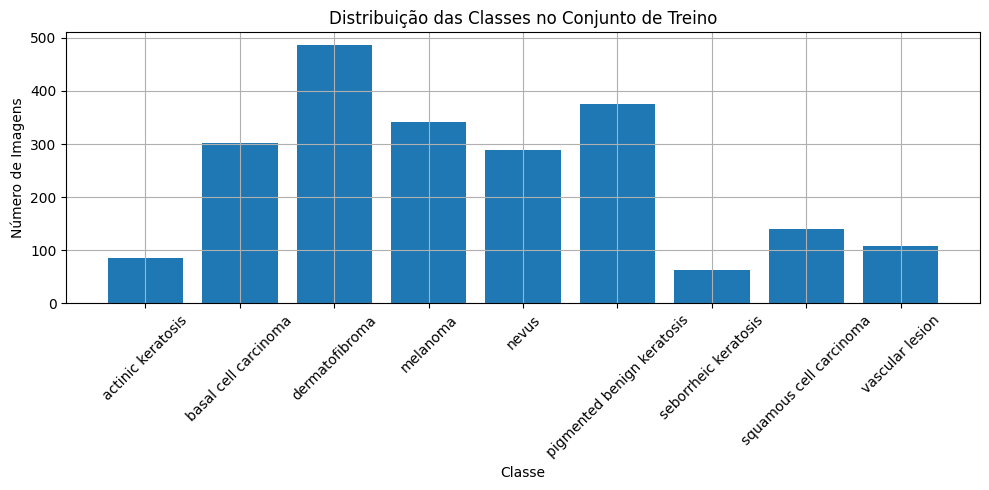

In [26]:
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())

unique, counts = np.unique(all_labels, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(class_names, counts)
plt.xticks(rotation=45)
plt.title("Distribuição das Classes no Conjunto de Treino")
plt.ylabel("Número de Imagens")
plt.xlabel("Classe")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
model_dropout_aug = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model_dropout_aug.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_dropout_aug = model_dropout_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.2506 - loss: 2.1013 - val_accuracy: 0.3199 - val_loss: 1.8380
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 296ms/step - accuracy: 0.3963 - loss: 1.6837 - val_accuracy: 0.3876 - val_loss: 1.6564
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.4467 - loss: 1.5538 - val_accuracy: 0.5265 - val_loss: 1.4349
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - accuracy: 0.4983 - loss: 1.4453 - val_accuracy: 0.4973 - val_loss: 1.4742
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - accuracy: 0.4926 - loss: 1.3879 - val_accuracy: 0.5192 - val_loss: 1.3426
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - accuracy: 0.5274 - loss: 1.3401 - val_accuracy: 0.5338 - val_loss: 1.4267
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 251ms/step - accuracy: 0.5434 - loss: 1.3165 - val_accuracy: 0.4991 - val_loss: 1.4179
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 252ms/step - accuracy: 0.5319 - loss: 1.2904 - val_accu

Após reforçar a classe `dermatofibroma` com 500 imagens sintéticas geradas pelo Augmentor, o modelo com `Dropout` foi treinado durante 30 épocas com o novo dataset aumentado.

O resultado foi muito positivo: a accuracy de validação atingiu aproximadamente **62.5%**, e a loss de validação manteve-se estável em torno de **1.20**. Estes valores indicam que o modelo aprendeu de forma eficaz e generalizou bem para os dados de validação, sem sinais evidentes de sobreajuste.

Conclui-se que a utilização do Augmentor para gerar mais exemplos de uma classe menos representada ajudou a melhorar o equilíbrio do dataset e contribuiu para o desempenho final do modelo.

## 6. Avaliação Final do Melhor Modelo

Esta avaliação refere-se ao **último modelo treinado**, que utilizou:
- `data augmentation` em tempo real
- regularização com `Dropout`
- dados aumentados com o `Augmentor` (oversampling da classe `dermatofibroma`)
- treino durante 30 épocas

Este foi o modelo com melhor desempenho geral, sendo por isso considerado o modelo final deste projeto.



### Visualização das Curvas de Desempenho

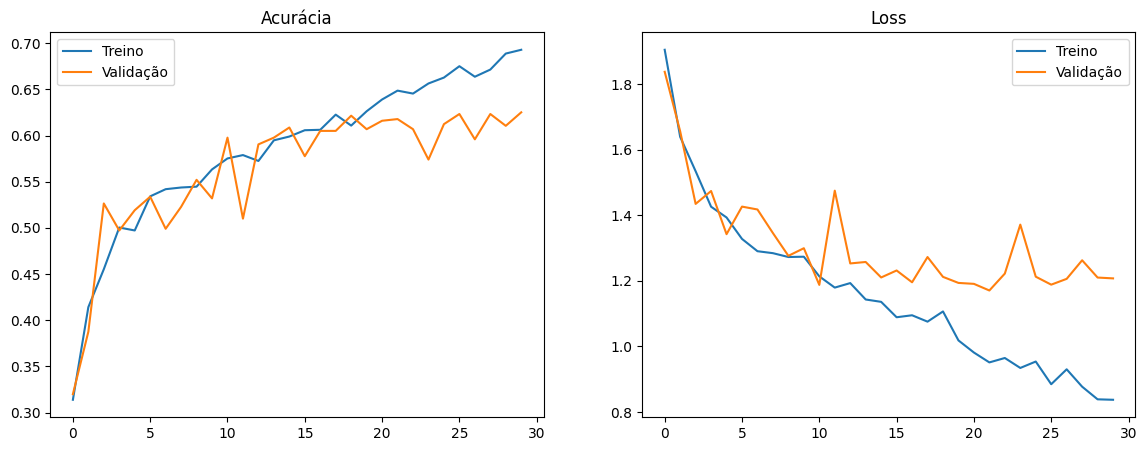

In [29]:
history = history_dropout_aug

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Treino')
plt.plot(val_acc, label='Validação')
plt.legend()
plt.title('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Treino')
plt.plot(val_loss, label='Validação')
plt.legend()
plt.title('Loss')
plt.show()

### Matriz de Confusão

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


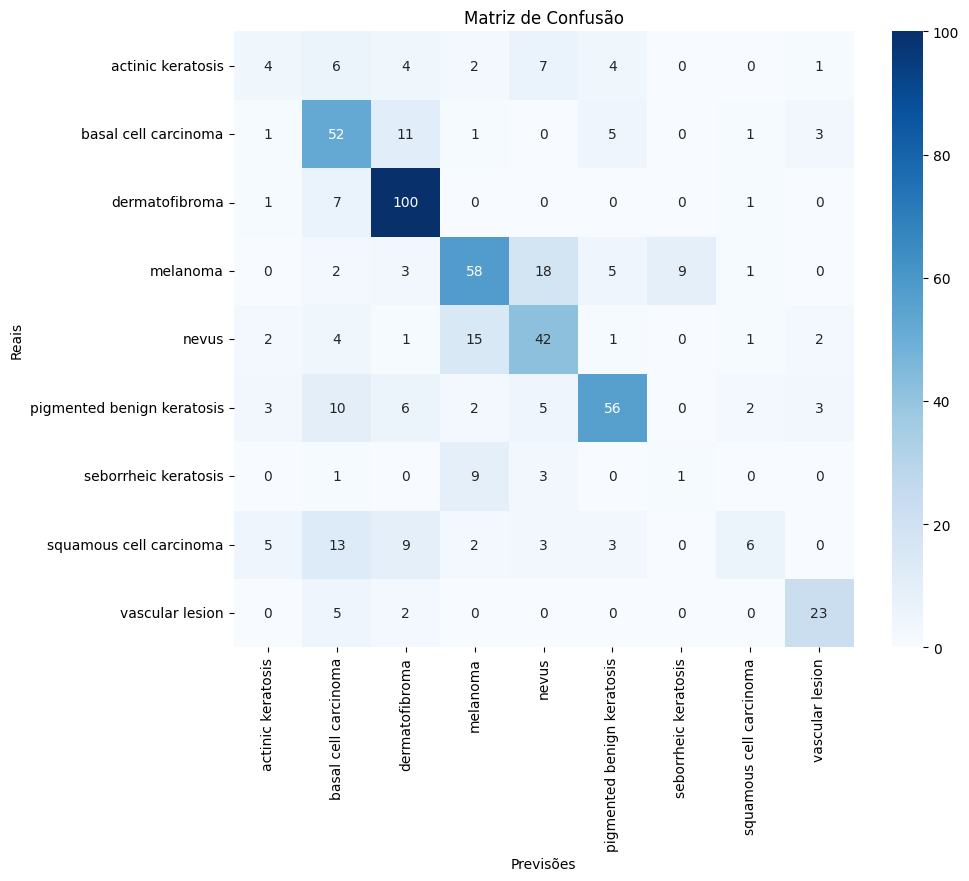

In [30]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model_dropout_aug.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Previsões")
plt.ylabel("Reais")
plt.title("Matriz de Confusão")
plt.show()

### Classification Report

In [31]:
print(classification_report(y_true, y_pred, target_names=class_names))

                            precision    recall  f1-score   support

         actinic keratosis       0.25      0.14      0.18        28
      basal cell carcinoma       0.52      0.70      0.60        74
            dermatofibroma       0.74      0.92      0.82       109
                  melanoma       0.65      0.60      0.63        96
                     nevus       0.54      0.62      0.58        68
pigmented benign keratosis       0.76      0.64      0.70        87
      seborrheic keratosis       0.10      0.07      0.08        14
   squamous cell carcinoma       0.50      0.15      0.23        41
           vascular lesion       0.72      0.77      0.74        30

                  accuracy                           0.63       547
                 macro avg       0.53      0.51      0.51       547
              weighted avg       0.61      0.63      0.60       547



- A accuracy de validação atingiu **63%**, com uma loss estável próxima de **1.2**
- A matriz de confusão revela um excelente desempenho na classe `dermatofibroma`, com um recall de **92%** e precisão de **74%**
- O modelo apresenta também bons resultados em classes como `melanoma`, `vascular lesion` e `pigmented benign keratosis`
- O `classification report` mostra um F1-score ponderado de **0.60**, reforçando a consistência do modelo


Estas métricas demonstram que a combinação de estratégias aplicadas permitiu obter um modelo equilibrado, com boa capacidade de generalização.  
O uso seletivo do Augmentor teve impacto direto na melhoria da classe aumentada, sem degradar a performance nas restantes.

## 7. Conclusão Final

Neste projeto, desenvolvi um modelo de classificação de imagens de lesões de pele com o objetivo de distinguir entre nove tipos de lesões.

Comecei por treinar um modelo base simples, onde rapidamente percebi sinais de overfitting. A introdução de técnicas como `data augmentation` e `dropout` ajudou a melhorar a capacidade do modelo em generalizar para novos dados.

Mais tarde, foi testado o uso do `class_weight` para tentar corrigir o desequilíbrio entre classes, mas os resultados não foram satisfatórios. A técnica mais eficaz acabou por ser o `Augmentor`, onde aumentei a classe `dermatofibroma`, que tinha poucos exemplos. Ao reforçar esta classe com imagens sintéticas, o modelo conseguiu classificá-la com mais confiança, o que se refletiu numa melhoria geral do desempenho.

O modelo final, treinado com dados aumentados e regularizado com `dropout`, alcançou uma accuracy de validação de aproximadamente **62%**, e apresentou estabilidade ao longo das 30 épocas de treino.


---

### Resumo comparativo das abordagens testadas:

| Modelo                              | Accuracy (validação) | Loss (validação) | Overfitting |
|-------------------------------------|-----------------------|------------------|-------------|
| CNN Base                            | ~51%                  | ~1.64            | Sim         |
| CNN com Data Augmentation           | ~54%                  | ~1.29            | Leve        |
| CNN com Dropout                     | ~59%                  | ~1.20            | Controlado  |
| CNN com Class Weight                | ~49%                  | >2.5             | Sim         |
| CNN com Dropout + Augmentor (final) | **62%**               | **~1.20**        | Não         |

---



### Decisões técnicas com maior impacto:

- A utilização de `dropout` foi essencial para melhorar a generalização.
- O `Augmentor` demonstrou ser eficaz mesmo quando aplicado a apenas uma classe minoritária.
- A combinação de `data augmentation` + `dropout` + `augmentor` revelou-se a mais estável.

---



### Reflexão e melhorias possíveis:

- Nem todas as classes foram aumentadas.
- Com mais imagens reais, especialmente das classes menos representadas, o modelo poderia aprender melhor e aumentar a sua precisão.
- Seria interessante aplicar `early stopping` para evitar treinos prolongados sem ganhos.
- Poderia ainda ser feita uma afinação de hiperparâmetros como a taxa de dropout, número de filtros e tamanho das camadas densas.

---





Apesar das limitações do dataset e do escopo do projeto, os resultados mostram uma evolução clara ao longo das diferentes fases e revelam o impacto direto das decisões tomadas em cada etapa do desenvolvimento. O modelo final demonstra um desempenho sólido e consistente, refletindo uma abordagem progressiva, bem justificada e alinhada com os objetivos propostos.
